In [1]:
import os
import sys

In [3]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from tqdm.notebook import tqdm
%matplotlib inline

In [12]:
from topology import PersistentHomologyCalculation
import numpy as np
import torch
import torch.nn as nn

class TopologicalSignatureDistance(nn.Module):
    """Topological signature."""

    def __init__(self, sort_selected=False, use_cycles=False,
                 match_edges=None):
        """Topological signature computation.
        Args:
            p: Order of norm used for distance computation
            use_cycles: Flag to indicate whether cycles should be used
                or not.
        """
        super().__init__()
        self.use_cycles = use_cycles

        self.match_edges = match_edges

        # if use_cycles:
        #     use_aleph = True
        # else:
        #     if not sort_selected and match_edges is None:
        #         use_aleph = True
        #     else:
        #         use_aleph = False

        # if use_aleph:
        #     print('Using aleph to compute signatures')
        ##self.signature_calculator = AlephPersistenHomologyCalculation(
        ##    compute_cycles=use_cycles, sort_selected=sort_selected)
        # else:
        print('Using python to compute signatures')
        self.signature_calculator = PersistentHomologyCalculation()

    def _get_pairings(self, distances):
        pairs_0, pairs_1 = self.signature_calculator(
            distances.detach().cpu().numpy())

        return pairs_0, pairs_1

    def _select_distances_from_pairs(self, distance_matrix, pairs):
        # Split 0th order and 1st order features (edges and cycles)
        pairs_0, pairs_1 = pairs
        selected_distances = distance_matrix[(pairs_0[:, 0], pairs_0[:, 1])]

        if self.use_cycles:
            edges_1 = distance_matrix[(pairs_1[:, 0], pairs_1[:, 1])]
            edges_2 = distance_matrix[(pairs_1[:, 2], pairs_1[:, 3])]
            edge_differences = edges_2 - edges_1

            selected_distances = torch.cat(
                (selected_distances, edge_differences))

        return selected_distances

    @staticmethod
    def sig_error(signature1, signature2):
        """Compute distance between two topological signatures."""
        return ((signature1 - signature2)**2).sum(dim=-1)

    @staticmethod
    def _count_matching_pairs(pairs1, pairs2):
        def to_set(array):
            return set(tuple(elements) for elements in array)
        return float(len(to_set(pairs1).intersection(to_set(pairs2))))

    @staticmethod
    def _get_nonzero_cycles(pairs):
        all_indices_equal = np.sum(pairs[:, [0]] == pairs[:, 1:], axis=-1) == 3
        return np.sum(np.logical_not(all_indices_equal))

    # pylint: disable=W0221
    def forward(self, distances1, distances2):
        """Return topological distance of two pairwise distance matrices.
        Args:
            distances1: Distance matrix in space 1
            distances2: Distance matrix in space 2
        Returns:
            distance, dict(additional outputs)
        """
        pairs1 = self._get_pairings(distances1)
        pairs2 = self._get_pairings(distances2)

        distance_components = {
            'metrics.matched_pairs_0D': self._count_matching_pairs(
                pairs1[0], pairs2[0])
        }
        # Also count matched cycles if present
        if self.use_cycles:
            distance_components['metrics.matched_pairs_1D'] = \
                self._count_matching_pairs(pairs1[1], pairs2[1])
            nonzero_cycles_1 = self._get_nonzero_cycles(pairs1[1])
            nonzero_cycles_2 = self._get_nonzero_cycles(pairs2[1])
            distance_components['metrics.non_zero_cycles_1'] = nonzero_cycles_1
            distance_components['metrics.non_zero_cycles_2'] = nonzero_cycles_2

        if self.match_edges is None:
            sig1 = self._select_distances_from_pairs(distances1, pairs1)
            sig2 = self._select_distances_from_pairs(distances2, pairs2)
            distance = self.sig_error(sig1, sig2)

        elif self.match_edges == 'symmetric':
            sig1 = self._select_distances_from_pairs(distances1, pairs1)
            sig2 = self._select_distances_from_pairs(distances2, pairs2)
            # Selected pairs of 1 on distances of 2 and vice versa
            sig1_2 = self._select_distances_from_pairs(distances2, pairs1)
            sig2_1 = self._select_distances_from_pairs(distances1, pairs2)

            distance1_2 = self.sig_error(sig1, sig1_2)
            distance2_1 = self.sig_error(sig2, sig2_1)

            distance_components['metrics.distance1-2'] = distance1_2
            distance_components['metrics.distance2-1'] = distance2_1

            distance = distance1_2 + distance2_1

        elif self.match_edges == 'random':
            # Create random selection in oder to verify if what we are seeing
            # is the topological constraint or an implicit latent space prior
            # for compactness
            n_instances = len(pairs1[0])
            pairs1 = torch.cat([
                torch.randperm(n_instances)[:, None],
                torch.randperm(n_instances)[:, None]
            ], dim=1)
            pairs2 = torch.cat([
                torch.randperm(n_instances)[:, None],
                torch.randperm(n_instances)[:, None]
            ], dim=1)

            sig1_1 = self._select_distances_from_pairs(
                distances1, (pairs1, None))
            sig1_2 = self._select_distances_from_pairs(
                distances2, (pairs1, None))

            sig2_2 = self._select_distances_from_pairs(
                distances2, (pairs2, None))
            sig2_1 = self._select_distances_from_pairs(
                distances1, (pairs2, None))

            distance1_2 = self.sig_error(sig1_1, sig1_2)
            distance2_1 = self.sig_error(sig2_1, sig2_2)
            distance_components['metrics.distance1-2'] = distance1_2
            distance_components['metrics.distance2-1'] = distance2_1

            distance = distance1_2 + distance2_1

        return distance, distance_components

### Exp many clusters

In [23]:
np.random.seed(7)

all_clusters = []

for i in range(60):
    all_clusters.append(np.random.multivariate_normal(np.zeros(2), np.eye(2), 5))
    
A_base = np.concatenate(all_clusters)

In [24]:
def split2clusters(k):
    
    if k == 1:
        return A_base
    
    arr = []
    
    for i in range(60):
        idx = i % k
    
        theta = 2 * np.pi * idx / k
        d = np.array([np.cos(theta), np.sin(theta)]) * 10
        
        arr.append(all_clusters[i] + d)
        
    A_mod = np.concatenate(arr)
    
    return A_mod

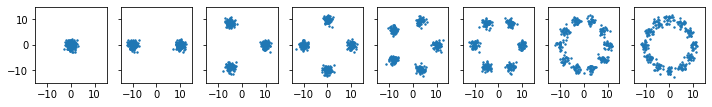

In [45]:
ALL = [2, 3, 4, 5, 6, 10, 12]

fig, ax = plt.subplots(1, len(ALL) + 1)
fig.set_size_inches(12, 1.4)

for idx, k in enumerate([0] + ALL):
    
    if idx == 0:
        A = A_base
    else:
        A = split2clusters(k)

    ax[idx].scatter(x = A[:,0], y = A[:,1], s = 2)
    ax[idx].set_xlim(-15, 15)
    ax[idx].set_ylim(-15, 15)
    
for ax in fig.get_axes():
    ax.label_outer()

In [51]:
tsd = TopologicalSignatureDistance({})

Using python to compute signatures


In [63]:
%%time
res = []

for i, k in enumerate(ALL):
    A_mod = split2clusters(k)
    
    r1 = pairwise_distances(A_base, A_base)
    r2 = pairwise_distances(A_mod, A_mod)
    
    r1 = torch.Tensor(r1)
    r2 = torch.Tensor(r2)
    
    #r1 /= r1.max()
    #r2 /= r2.max()
    
    res.append(tsd(r1, r2)[0].item())

CPU times: user 50.5 s, sys: 4.75 s, total: 55.2 s
Wall time: 3.78 s


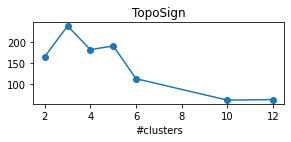

In [64]:
clusters_list = [2, 3, 4, 5, 6, 10, 12]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((4.5, 1.5))
plt.plot(clusters_list, res[:len(clusters_list)], 'o-', label = 'base/mod')
ax.set_xlabel('#clusters')
plt.title('TopoSign')
plt.show()

In [65]:
stats.kendalltau(res, clusters_list).correlation

-0.5238095238095238

In [67]:
r2.max()

tensor(24.6107)

In [68]:
r1.max()

tensor(6.7068)